## Counterfactual Inference on Synthetic Toy Data
Here we try to recreate the experiment in Section 4.2 of [Louizos, Christos, et al. 2017](http://papers.nips.cc/paper/7223-causal-effect-inference-with-deep-latent-variable-models.pdf)

Data point $X$ is assumed to be a mixture of gaussians, with hidden variable $Z$ determining the mixture components. The data of generated in the following way:

$z_i \sim Bern(0.5)$

$x_i|z_i \sim \mathcal{N} (z_i, \sigma_{z_1}^2 z_i + \sigma_{z_0}^2 (1 - z_i))$

$t_i|z_i \sim Bern(0.75 z_i + 0.25(1 - z_i))$

$y_i|t_i, z_i \sim Bern(Sigmoid(3(z_i + 2(2t_i - 1))))$

where $\sigma_{z_0}=3$ and $\sigma_{z_1}=5$


## Tentative Results

| Model   | Num Samples | PEHE   | Abs ATE Err.     |
| ------- | ----------- | ------ | ---------------- |
| Dumb    | 1000        | 0.0290 | 0.0270           |
|         | 3000        | 0.0253 | 0.0253           |
|         | 5000        | 0.0232 | 0.0232           |
|         | 10000       | 0.0278 | 0.0278           |
|         |             |        |                  |
| Twin RF | 1000        | 0.9800 | 0.9700           |
|         | 3000        | 0.9800 | 0.9800           |
|         | 5000        | 0.9730 | 0.9730           |
|         | 10000       | 0.9745 | 0.9745           |
|         |             |        |                  |
| TARNet  | 1000        | 0.0450 | 0.0350           |
|         | 3000        | 0.0250 | 0.0250           |
|         | 5000        | 0.0240 | 0.0240           |
|         | 10000       | 0.0240 | 0.0240           |
|         |             |        |                  |
| CEVAE   | 1000        | 0.4750 | 0.4700 (0.0387?) |
|         | 3000        | 0.9333 | 0.9300           |
|         | 5000        | 0.7230 | 0.7150           |
|         | 10000       | 0.1003 | 0.0848           |

Note:
- CEVAE and TARNet were trained for 20 epochs
- TARNet model does not have MMD regularization
- Current models have not been tuned properly nor have they been regularized (DO, etc)
- Validation results != Test results



In [1]:
#!pip install pytorch-ignite

In [2]:
#!conda install scikit-learn

In [3]:
import os
import math, random
import scipy.stats as stats
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('whitegrid')

import torch
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
import ignite.metrics as ignite_metrics

In [4]:
# Fix constants and helper methods
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def rounded_sigmoid(logits: torch.Tensor) -> torch.Tensor:
    return torch.round(torch.sigmoid(logits))


def seed_everything(seed: int) -> None:
    "seeding function for reproducibility"
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
NUM_SAMPLES = 1000
P0 = 0.5
SIG_Z0 = 3
SIG_Z1 = 5  
T_TAU_Z0 = 0.75
T_TAU_Z1 = 0.25
# visualize tau (represents the prob of getting y = 1, 
# i.e y = Bern(tau))
TAU = np.zeros((2, 2))
for z in range(2):
    for t in range(2):
        # TAU[z, t] = sigmoid(3 * (z + 2 * (2 * t - 1))) # original
        TAU[z, t] = sigmoid(1.5 * (z + 1.3 * (2 * t - 1)))

PLOT_STYLE = 'ggplot'      

seed_everything(123)

In [5]:
def prepare_data_df(num_samples, sig_z0, sig_z1) -> pd.DataFrame:
    # First sample from Bernoulli for z_i
    z_dist = dist.Bernoulli(probs=P0)
    zs = z_dist.sample((NUM_SAMPLES, ))
    print(f"Sanity checking z_dist:\n{zs.mean():.3f}")
    df = pd.DataFrame(zs.numpy(), columns=['z'])

    # Next sampling t_i and x_i from z_i
    x_s, t_s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        x_var = (np.square(sig_z1) * z_i + np.square(sig_z0) * (1 - z_i))
        x_sample = dist.Normal(
            loc=z_i, 
            scale=np.sqrt(x_var)
        ).sample()
        x_s.append(x_sample.item())
        
        t_sample = dist.Bernoulli(T_TAU_Z0 * z_i + T_TAU_Z1 * (1 - z_i)).sample()
        t_s.append(t_sample.item())

    df['X'] = x_s
    df['t'] = t_s

    # Lastly sample y_i conditioned on z_i and t_i
    y0s, y1s = [], []
    for idx in df.index:
        z_i = df.loc[idx, 'z']
        t_i = df.loc[idx, 't']

        # outcome when t = 0
        y0_sample = dist.Bernoulli(TAU[int(z_i), 0]).sample()
        y0s.append(y0_sample.item())

        # outcome when t = 1
        y1_sample = dist.Bernoulli(TAU[int(z_i), 1]).sample()
        y1s.append(y1_sample.item())
        
    df['y0'] = y0s # untreated outcome for given z
    df['y1'] = y1s # treated outcome for given z
    df['yf'] =  np.where(df['t'] == 0, df['y0'], df['y1'])

    print(f"t value  counts:\n{df['t'].value_counts()}")
    print(f"y0 value counts:\n{df['y0'].value_counts()}")
    print(f"y1 value  counts:\n{df['y1'].value_counts()}")

    return df

def visualize_data(df: pd.DataFrame) -> None:
    # Visualize the generated data
    with plt.style.context(PLOT_STYLE):
        kwargs = dict(bins=50, )
        fig, ax = plt.subplots(3, 2, figsize=(10, 15))
        sns.distplot(df.query("z == 0")['X'], ax=ax[0, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1")['X'], ax=ax[0, 0], label='z = 1', **kwargs)
        ax[0, 0].axvline(df.query("z == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].axvline(df.query("z == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_title('p(X|z)')
        ax[0, 0].legend()


        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=TAU[0, 0], ax=ax[0, 1], label='z = 0, t = 0')
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=TAU[1, 0], ax=ax[0, 1], label='z = 1, t = 0')
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=TAU[0, 1], ax=ax[0, 1], label='z = 0, t = 1')
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=TAU[1, 1], ax=ax[0, 1], label='z = 1, t = 1')
        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(y=1|z, t)')
        ax[0, 1].legend()

        sns.distplot(df.query("z == 0 & t == 0")['X'], ax=ax[1, 0], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 0")['X'], ax=ax[1, 0], label='z = 1', **kwargs)
        ax[1, 0].axvline(df.query("z == 0 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].axvline(df.query("z == 1 & t == 0")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_title('Untreated p(X|z)')
        ax[1, 0].legend()

        sns.distplot(df.query("z == 0 & t == 1")['X'], ax=ax[1, 1], label='z = 0', **kwargs)
        sns.distplot(df.query("z == 1 & t == 1")['X'], ax=ax[1, 1], label='z = 1', **kwargs)
        ax[1, 1].axvline(df.query("z == 0 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].axvline(df.query("z == 1 & t == 1")['X'].mean(), color="gray", linestyle="dotted")
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_title('Treated p(X|z)')
        ax[1, 1].legend()
        ;

        sns.scatterplot(x=df.query("z == 0 & t == 0")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 0 & t == 1")['X'], y=0.25, ax=ax[2, 0], label='z = 0, t = 1', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 0")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 0', alpha=0.7)
        sns.scatterplot(x=df.query("z == 1 & t == 1")['X'], y=0.75, ax=ax[2, 0], label='z = 1, t = 1', alpha=0.7)
        ax[2, 0].set_xlabel('X')
        ax[2, 0].set_title('Propensity p(t|z)')
        ax[2, 0].legend();


        sns.distplot(df.query("t == 0")['X'], ax=ax[2, 1], label='t = 0')
        sns.distplot(df.query("t == 1")['X'], ax=ax[2, 1], label='t = 1')
        ax[2, 1].set_xlabel('X')
        ax[2, 1].set_title('Propensity p(t|X)')
        ax[2, 1].legend();        

        return

def visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1):
    x_grid = np.linspace(-15, 15, 100)
    norm_z0 = stats.norm(0, SIG_Z0) # cluster 1
    norm_z1 = stats.norm(1, SIG_Z1) # cluster 2

    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        # p(z=1|X) ~ p(x|z=1) p(z=1)
        
        aux_z0 = P0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 0])
        ax[0, 0].set_xlabel('X')
        ax[0, 0].set_ylabel('prob')
        ax[0, 0].set_title('p(z=1|X)')

        # p(z=1|X, t) ~ p(X|z=1) p(t|z=1) p(z=1)
        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        curve = aux_z0 / (aux_z0 + aux_z1)
        sns.lineplot(x_grid, curve, ax=ax[0, 1], label='t = 0')

        ax[0, 1].set_xlabel('X')
        ax[0, 1].set_ylabel('prob')
        ax[0, 1].set_title('p(z=1|X, t)')

        # p(y=1|X, t) = 
        #   p(y=1|t, z=1) p(z=1|X, t) +
        #   p(y=1|t, z=0) p(z=0|X, t) 
        # = 
        #   p(y=1|t, z=1) p(z=1|X, t) + 
        #   p(y=1|t, z=0) (1 - p(z=1|X, t))

        aux_z0 = P0 * T_TAU_Z0 * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * T_TAU_Z1 * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=1)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 1] * pos_z + TAU[0, 1] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 1')

        aux_z0 = P0 * (1 - T_TAU_Z0) * norm_z1.pdf(x_grid)
        aux_z1 = (1 - P0) * (1 - T_TAU_Z1) * norm_z0.pdf(x_grid)
        pos_z = aux_z0 / (aux_z0 + aux_z1) # p(z=1|x, t=0)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[1, 0] * pos_z + TAU[0, 0] * (1 - pos_z)
        sns.lineplot(x_grid, curve, ax=ax[1, 0], label='t = 0')
        ax[1, 0].set_xlabel('X')
        ax[1, 0].set_ylabel('prob')
        ax[1, 0].set_title('p(y=1|X, t)')

        # p(y|X, do(t)) = 
        #   p(y|X, do(t), z=0) p(z=0|X, do(t)) +
        #   p(y|X, do(t), z=1) p(z=1|X, do(t))
        # =
        #   p(y|X, t, z=0) p(z=0|X, t) +
        #   p(y|X, t, z=1) p(z=1|X, t)
        aux_z0 = P0 * norm_z0.pdf(x_grid)
        aux_z1 = (1 - P0) * norm_z1.pdf(x_grid)
        pos_z0 = aux_z0 / (aux_z0 + aux_z1) # p(z=0|X)
        # TAU coords = 
        # z0_t0  z0_t1
        # z1_t0  z1_t1
        curve = TAU[0, 0] * pos_z0 + TAU[1, 0] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 0)')

        curve = TAU[0, 1] * pos_z0 + TAU[1, 1] * (1 - pos_z0)
        sns.lineplot(x_grid, curve, ax=ax[1, 1], label='do(t = 1)')
        ax[1, 1].set_xlabel('X')
        ax[1, 1].set_ylabel('prob')
        ax[1, 1].set_title('p(y=1|X, do(t))')


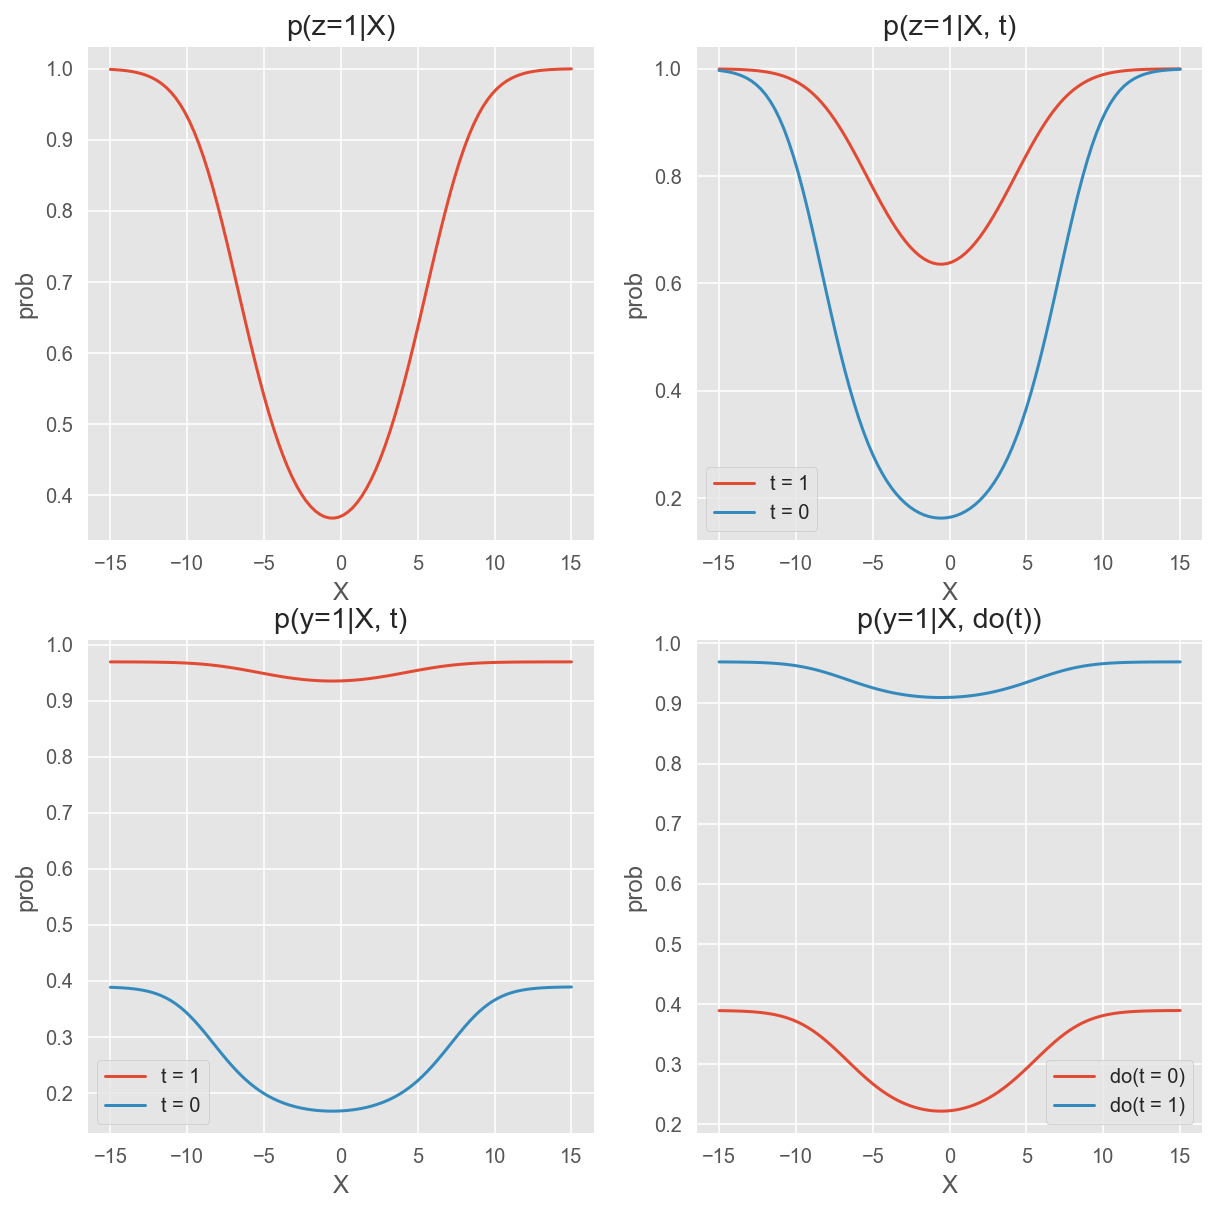

In [6]:
visualize_pdfs(P0, T_TAU_Z0, T_TAU_Z1, SIG_Z0, SIG_Z1)

Sanity checking z_dist:
0.501
t value  counts:
0.0    505
1.0    495
Name: t, dtype: int64
y0 value counts:
0.0    727
1.0    273
Name: y0, dtype: int64
y1 value  counts:
1.0    923
0.0     77
Name: y1, dtype: int64


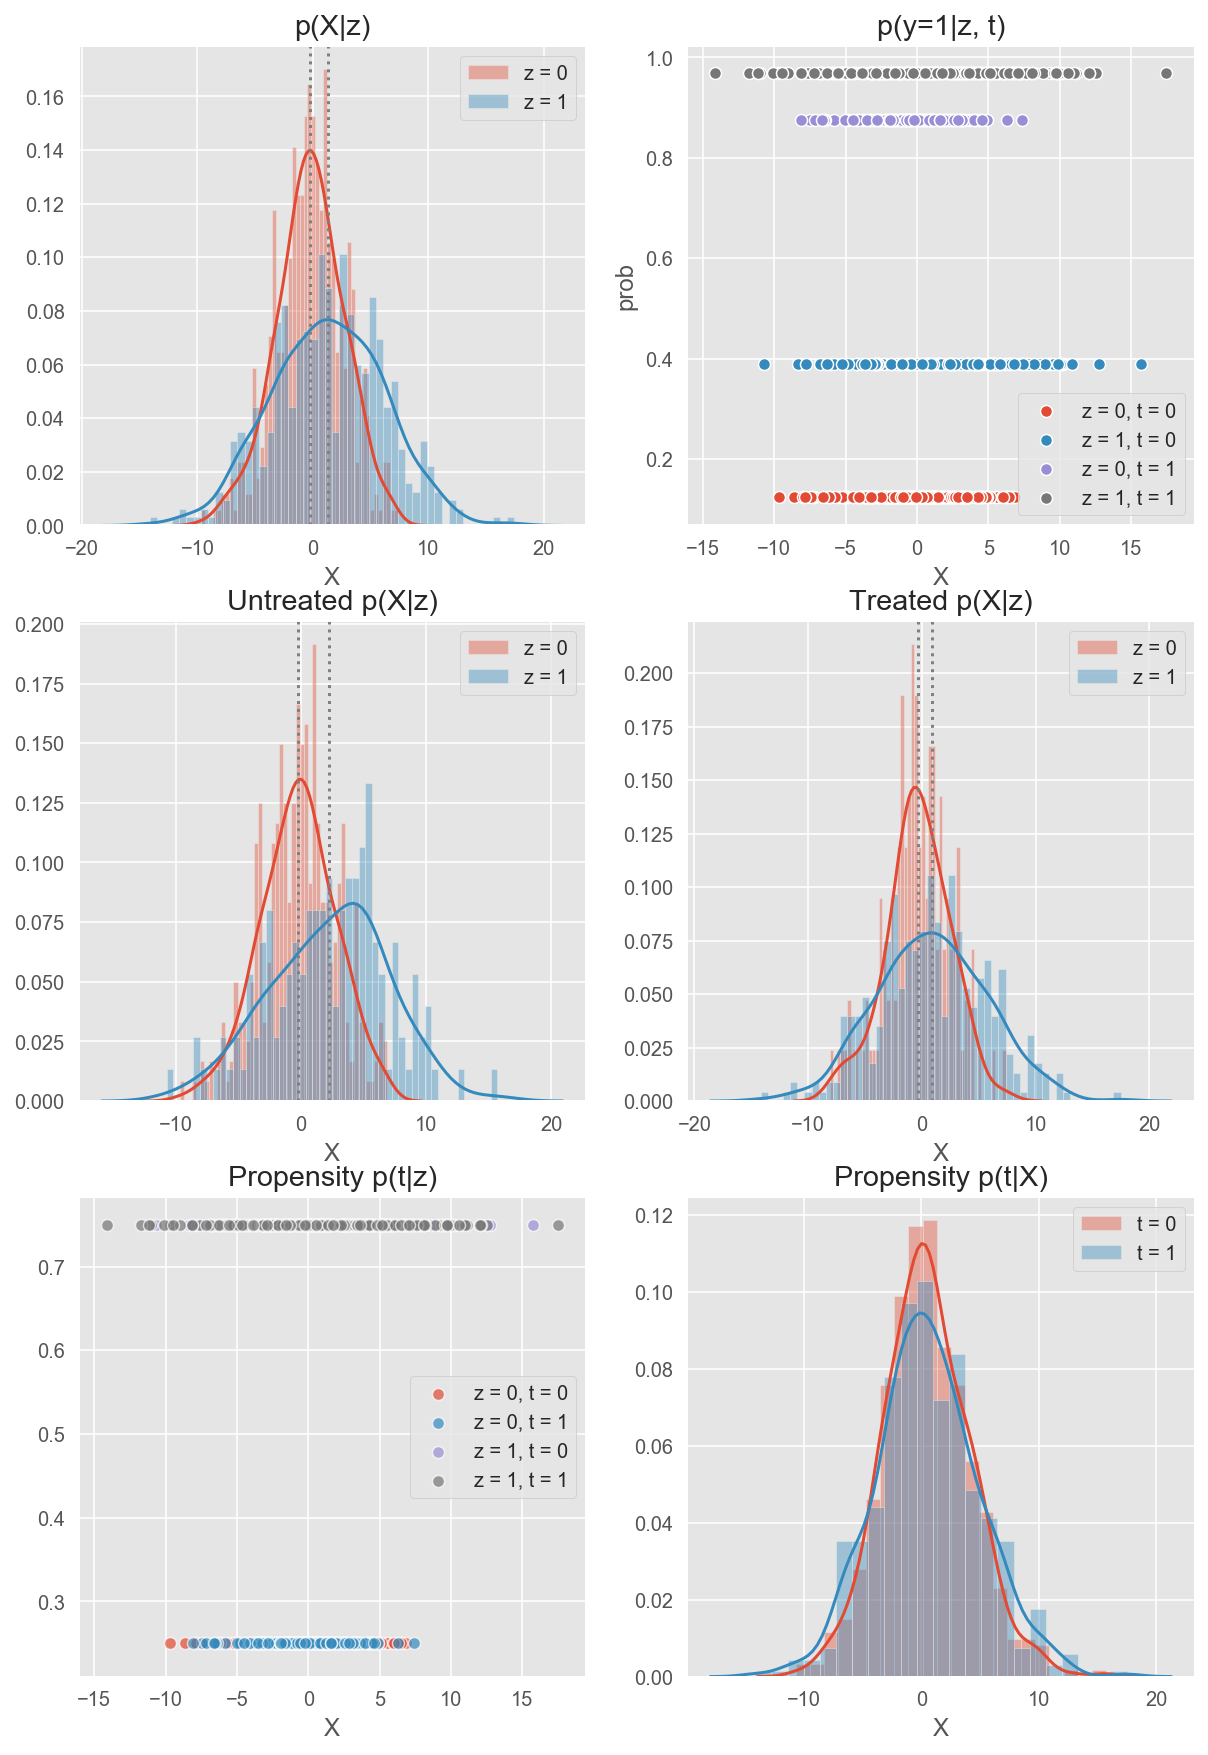

In [7]:
df = prepare_data_df(NUM_SAMPLES, SIG_Z0, SIG_Z1)
visualize_data(df)

In [8]:
# How well does a dumb model do?
print(f"Data size: {df.shape[0]}")
print("y0 value counts:")
print(df.y0.value_counts()/df.shape[0])
print("y1 value counts:")
print(df.y1.value_counts()/df.shape[0])
print("yf value counts:")
print(df.yf.value_counts()/df.shape[0])

# if the model could accurately predict the treatment
# it can then just choose 
# yf = 1 if t = 1 and yf = 0 if t = 0
# what will be the ITE and ATE and PEHE for this model?
y0_pred = np.zeros((df.shape[0],))
y1_pred = np.ones((df.shape[0],))

y0_true = df['y0'].values
y1_true = df['y1'].values

ite_pred = y1_pred - y0_pred
ite_true = y1_true - y0_true

print()
print("Metrics for dumb model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")

Data size: 1000
y0 value counts:
0.0    0.727
1.0    0.273
Name: y0, dtype: float64
y1 value counts:
1.0    0.923
0.0    0.077
Name: y1, dtype: float64
yf value counts:
1.0    0.567
0.0    0.433
Name: yf, dtype: float64

Metrics for dumb model with true treatment values:
PEHE: 0.3900
Abs ATE Err.: 0.3500


In [9]:
# Train two RF models for each treatment 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

rf0 = RandomForestClassifier()
rf1 = RandomForestClassifier()

X0_train= df_train.query("t == 0")['X'].values
y0_train = df_train.query("t == 0")['yf'].values
X1_train = df_train.query("t == 1")['X'].values
y1_train = df_train.query("t == 1")['yf'].values
X0_train.shape = (X0_train.size,1)
X1_train.shape = (X1_train.size,1)

X_test = df_test['X'].values
X_test.shape = (X_test.size,1)
y0_test = df_test['y0'].values
y1_test = df_test['y1'].values

rf0.fit(X0_train, y0_train)
rf1.fit(X1_train, y1_train)

y0_pred = rf0.predict(X_test)
y1_pred = rf1.predict(X_test)

ite_pred = y1_pred - y0_pred
ite_true = y1_test - y0_test

print()
print("Metrics for Twin RF Model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")


Metrics for Twin RF Model with true treatment values:
PEHE: 0.5450
Abs ATE Err.: 0.1050


In [10]:
# Train two RF models for each treatment 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

rf0 = RandomForestClassifier()
rf1 = RandomForestClassifier()

X0_train= df_train.query("t == 0")['X'].values
X0_train = np.column_stack([X0_train, np.zeros(X0_train.shape[0],)])
y0_train = df_train.query("t == 0")['yf'].values
X1_train = df_train.query("t == 1")['X'].values
X1_train = np.column_stack([X1_train, np.ones(X1_train.shape[0],)])
y1_train = df_train.query("t == 1")['yf'].values

X_test = df_test['X'].values
y0_test = df_test['y0'].values
y1_test = df_test['y1'].values

rf0.fit(X0_train, y0_train)
rf1.fit(X1_train, y1_train)

y0_pred = rf0.predict(np.column_stack([X_test, np.zeros(X_test.shape[0],)]))
y1_pred = rf1.predict(np.column_stack([X_test, np.ones(X_test.shape[0],)]))

ite_pred = y1_pred - y0_pred
ite_true = y1_test - y0_test

print()
print("Metrics for Twin RF Model with true treatment values:")
print(f"PEHE: {np.mean(np.square(ite_true - ite_pred)):.4f}")
print(f"Abs ATE Err.: {np.abs(np.mean(ite_true) - np.mean(ite_pred)):.4f}")


Metrics for Twin RF Model with true treatment values:
PEHE: 0.5450
Abs ATE Err.: 0.1050


In [11]:
df.X.describe()

count    1000.000000
mean        0.526696
std         4.078706
min       -14.130157
25%        -2.080764
50%         0.346386
75%         3.126247
max        17.474087
Name: X, dtype: float64

In [12]:
# Define pytorch datasets and loaders
class ToyDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.length = data.shape[0]
        self.t = data.loc[:, 't'].values
        self.X = data.loc[:, 'X'].values
        self.y0 = data.loc[:, 'y0'].values
        self.y1 = data.loc[:, 'y1'].values
        self.yf = data.loc[:, 'yf'].values

    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            't': self.t[idx],
            'y0': self.y0[idx],
            'y1': self.y1[idx],
            'yf': self.yf[idx]
        }

    def __len__(self):
        return self.length


class ToyDataLoader(DataLoader):
    def __init__(self, dataset, validation_split=0.2, shuffle=True):
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(validation_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, valid_indices = indices[split:], indices[: split]

        self.dataset = dataset
        self.train_sampler = SubsetRandomSampler(train_indices)
        self.valid_sampler = SubsetRandomSampler(valid_indices)

    def collate_fn(self, batch):
        keys = list(batch[0].keys())
        processed_batch = {k: [] for k in keys}
        for _, sample in enumerate(batch):
            for key, value in sample.items():
                processed_batch[key].append(value)
        
        processed_batch['t'] = torch.FloatTensor(processed_batch['t'])
        processed_batch['X'] = torch.FloatTensor(processed_batch['X'])
        processed_batch['y0'] = torch.FloatTensor(processed_batch['y0'])
        processed_batch['y1'] = torch.FloatTensor(processed_batch['y1'])
        processed_batch['yf'] = torch.FloatTensor(processed_batch['yf'])
        return processed_batch

    def train_loader(self, batch_size, num_workers=0):
        train_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.train_sampler,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True
        )

        return train_loader

    def test_loader(self, batch_size, num_workers=0):
        test_loader = DataLoader(
            dataset=self.dataset,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            sampler=self.valid_sampler,
            num_workers=num_workers,
            pin_memory=True,
            shuffle=False,
            drop_last=True
        )

        return test_loader

    def get_loaders(self, batch_size):
        train_loader = self.train_loader(batch_size)
        test_loader = self.test_loader(batch_size)

        return train_loader, test_loader

## Model Architectures

- TARNet
- CEVAE


In [13]:
# Training Constants
LR = 3e-4
BATCH_SIZE = 8
NUM_EPOCHS = 20
BATCH_PER_EPOCH = NUM_SAMPLES/BATCH_SIZE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = ToyDataset(df)
dataloader = ToyDataLoader(dataset, validation_split=0.2)
train_loader, test_loader = dataloader.get_loaders(batch_size=BATCH_SIZE)

In [14]:
# for i, batch in enumerate(test_loader):
#     print(batch['X'].shape)

In [15]:
LBOUND = 1e-5
UBOUND = 1e+7

def safe_sqrt(x, lbound=LBOUND, ubound=UBOUND):
    ''' Numerically safe version of sqrt '''
    torch.clamp(x, min=lbound, max=ubound)
    return torch.sqrt(x)

def safe_square(x, lbound=LBOUND, ubound=UBOUND):
    ''' Numerically safe version of square '''
    torch.clamp(x, min=lbound, max=ubound)
    return torch.pow(x, 2)

def mmd2_lin(phi_x, t, p):
    """
    Linear MMD
    ----------
    phi_x: representation of input X after some NN layers
    t (boolean): treatment flag
    p (float): treatment probability
    https://github.com/clinicalml/cfrnet/blob/504cc6d012865caf14dbc6d5c88a0078037f0bd3/cfr/util.py#L103
    Computing MMD: https://stats.stackexchange.com/a/276618
    """
    treated_idx = torch.where(t == 1)[0]
    control_idx = torch.where(t == 0)[0]

    phi_xc = phi_x[control_idx, :]
    phi_xt = phi_x[treated_idx, :]

    mean_control = torch.mean(phi_xc, dim=0)
    mean_treated = torch.mean(phi_xt, dim=0)
    import pdb; pdb.set_trace()
    mmd = torch.sum(safe_square(
        2.0 * p * mean_treated - 2.0 * (1.0 - p) * mean_control))
    print(mmd)
    return mmd


class TARNet(nn.Module):
    def __init__(self, input_dim, activation=nn.ELU(), z_dim=2, device='cpu'):
        super().__init__()

        self.input_dim = input_dim
        self.z_dim = z_dim

        self.shared_head = nn.Sequential(
            # nn.Linear(input_dim, 4),
            # activation,
            # nn.Linear(16, 8),
            # activation,
            nn.Linear(input_dim, z_dim),
            activation
        )
        self.t0_head = nn.Sequential(
            nn.Linear(z_dim, 1),
            activation,
            # nn.Linear(4, 1),
            # activation
        )
        self.t1_head = nn.Sequential(
            nn.Linear(z_dim, 1),
            activation,
            # nn.Linear(4, 1),
            # activation
        )
        # self.apply(self.init_weights)
        self.to(device)
        self.float()

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        x = x.reshape(-1, 1)
        phi_x = self.shared_head(x)

        y0_pred = self.t0_head(phi_x).squeeze(-1)
        y1_pred = self.t1_head(phi_x).squeeze(-1)

        return y0_pred, y1_pred, phi_x

In [16]:
device = "cpu"

Training Results - Epoch 1 - Avg yf loss: 0.6267 Avg loss: 0.6267 PEHE: 1.2475 MAE ATE: 0.8588 acc: 0.4612 true ITE: 5.0900 pred ITE: -1.6700 precision: 0.5254.
Validate Results - Epoch 1 - Avg yf loss: 0.6182 Avg loss: 0.6182 PEHE: 1.3600 MAE ATE: 0.9300 acc: 0.3950 true ITE: 5.6400 pred ITE: -1.8000 precision: 0.4655.
Training Results - Epoch 2 - Avg yf loss: 0.6231 Avg loss: 0.6231 PEHE: 1.1863 MAE ATE: 0.8213 acc: 0.4750 true ITE: 5.0900 pred ITE: -1.3400 precision: 0.5386.
Validate Results - Epoch 2 - Avg yf loss: 0.6136 Avg loss: 0.6136 PEHE: 1.3050 MAE ATE: 0.8900 acc: 0.4000 true ITE: 5.6400 pred ITE: -1.4400 precision: 0.4690.
Training Results - Epoch 3 - Avg yf loss: 0.6196 Avg loss: 0.6196 PEHE: 1.1400 MAE ATE: 0.7887 acc: 0.4863 true ITE: 5.0900 pred ITE: -1.0500 precision: 0.5499.
Validate Results - Epoch 3 - Avg yf loss: 0.6091 Avg loss: 0.6091 PEHE: 1.2100 MAE ATE: 0.8413 acc: 0.4300 true ITE: 5.6400 pred ITE: -0.9200 precision: 0.4955.
Training Results - Epoch 4 - Avg y

Training Results - Epoch 27 - Avg yf loss: 0.5841 Avg loss: 0.5841 PEHE: 0.5437 MAE ATE: 0.4869 acc: 0.6713 true ITE: 5.0900 pred ITE: 4.4000 precision: 0.9401.
Validate Results - Epoch 27 - Avg yf loss: 0.5649 Avg loss: 0.5649 PEHE: 0.4800 MAE ATE: 0.4750 acc: 0.7000 true ITE: 5.6400 pred ITE: 4.3600 precision: 0.9818.
Training Results - Epoch 28 - Avg yf loss: 0.5834 Avg loss: 0.5834 PEHE: 0.5400 MAE ATE: 0.4859 acc: 0.6725 true ITE: 5.0900 pred ITE: 4.4300 precision: 0.9404.
Validate Results - Epoch 28 - Avg yf loss: 0.5640 Avg loss: 0.5640 PEHE: 0.4750 MAE ATE: 0.4738 acc: 0.7000 true ITE: 5.6400 pred ITE: 4.4000 precision: 0.9818.
Training Results - Epoch 29 - Avg yf loss: 0.5827 Avg loss: 0.5827 PEHE: 0.5375 MAE ATE: 0.4844 acc: 0.6737 true ITE: 5.0900 pred ITE: 4.4500 precision: 0.9406.
Validate Results - Epoch 29 - Avg yf loss: 0.5632 Avg loss: 0.5632 PEHE: 0.4750 MAE ATE: 0.4738 acc: 0.7000 true ITE: 5.6400 pred ITE: 4.4000 precision: 0.9818.
Training Results - Epoch 30 - Avg 

Training Results - Epoch 53 - Avg yf loss: 0.5704 Avg loss: 0.5704 PEHE: 0.5150 MAE ATE: 0.4637 acc: 0.6950 true ITE: 5.0900 pred ITE: 4.9100 precision: 0.9412.
Validate Results - Epoch 53 - Avg yf loss: 0.5479 Avg loss: 0.5479 PEHE: 0.4400 MAE ATE: 0.4450 acc: 0.7200 true ITE: 5.6400 pred ITE: 5.0000 precision: 0.9672.
Training Results - Epoch 54 - Avg yf loss: 0.5700 Avg loss: 0.5700 PEHE: 0.5162 MAE ATE: 0.4637 acc: 0.6950 true ITE: 5.0900 pred ITE: 4.9200 precision: 0.9412.
Validate Results - Epoch 54 - Avg yf loss: 0.5474 Avg loss: 0.5474 PEHE: 0.4400 MAE ATE: 0.4450 acc: 0.7200 true ITE: 5.6400 pred ITE: 5.0000 precision: 0.9672.
Training Results - Epoch 55 - Avg yf loss: 0.5696 Avg loss: 0.5696 PEHE: 0.5175 MAE ATE: 0.4637 acc: 0.6950 true ITE: 5.0900 pred ITE: 4.9300 precision: 0.9412.
Validate Results - Epoch 55 - Avg yf loss: 0.5469 Avg loss: 0.5469 PEHE: 0.4400 MAE ATE: 0.4450 acc: 0.7200 true ITE: 5.6400 pred ITE: 5.0000 precision: 0.9672.
Training Results - Epoch 56 - Avg 

Training Results - Epoch 79 - Avg yf loss: 0.5346 Avg loss: 0.5346 PEHE: 0.4138 MAE ATE: 0.3638 acc: 0.8538 true ITE: 5.0900 pred ITE: 8.0000 precision: 0.9288.
Validate Results - Epoch 79 - Avg yf loss: 0.5032 Avg loss: 0.5032 PEHE: 0.2950 MAE ATE: 0.2950 acc: 0.9150 true ITE: 5.6400 pred ITE: 8.0000 precision: 0.9706.
Training Results - Epoch 80 - Avg yf loss: 0.5320 Avg loss: 0.5320 PEHE: 0.4138 MAE ATE: 0.3638 acc: 0.8538 true ITE: 5.0900 pred ITE: 8.0000 precision: 0.9288.
Validate Results - Epoch 80 - Avg yf loss: 0.4998 Avg loss: 0.4998 PEHE: 0.2950 MAE ATE: 0.2950 acc: 0.9150 true ITE: 5.6400 pred ITE: 8.0000 precision: 0.9706.
Training Results - Epoch 81 - Avg yf loss: 0.5295 Avg loss: 0.5295 PEHE: 0.4138 MAE ATE: 0.3638 acc: 0.8538 true ITE: 5.0900 pred ITE: 8.0000 precision: 0.9288.
Validate Results - Epoch 81 - Avg yf loss: 0.4965 Avg loss: 0.4965 PEHE: 0.2950 MAE ATE: 0.2950 acc: 0.9150 true ITE: 5.6400 pred ITE: 8.0000 precision: 0.9706.
Training Results - Epoch 82 - Avg 

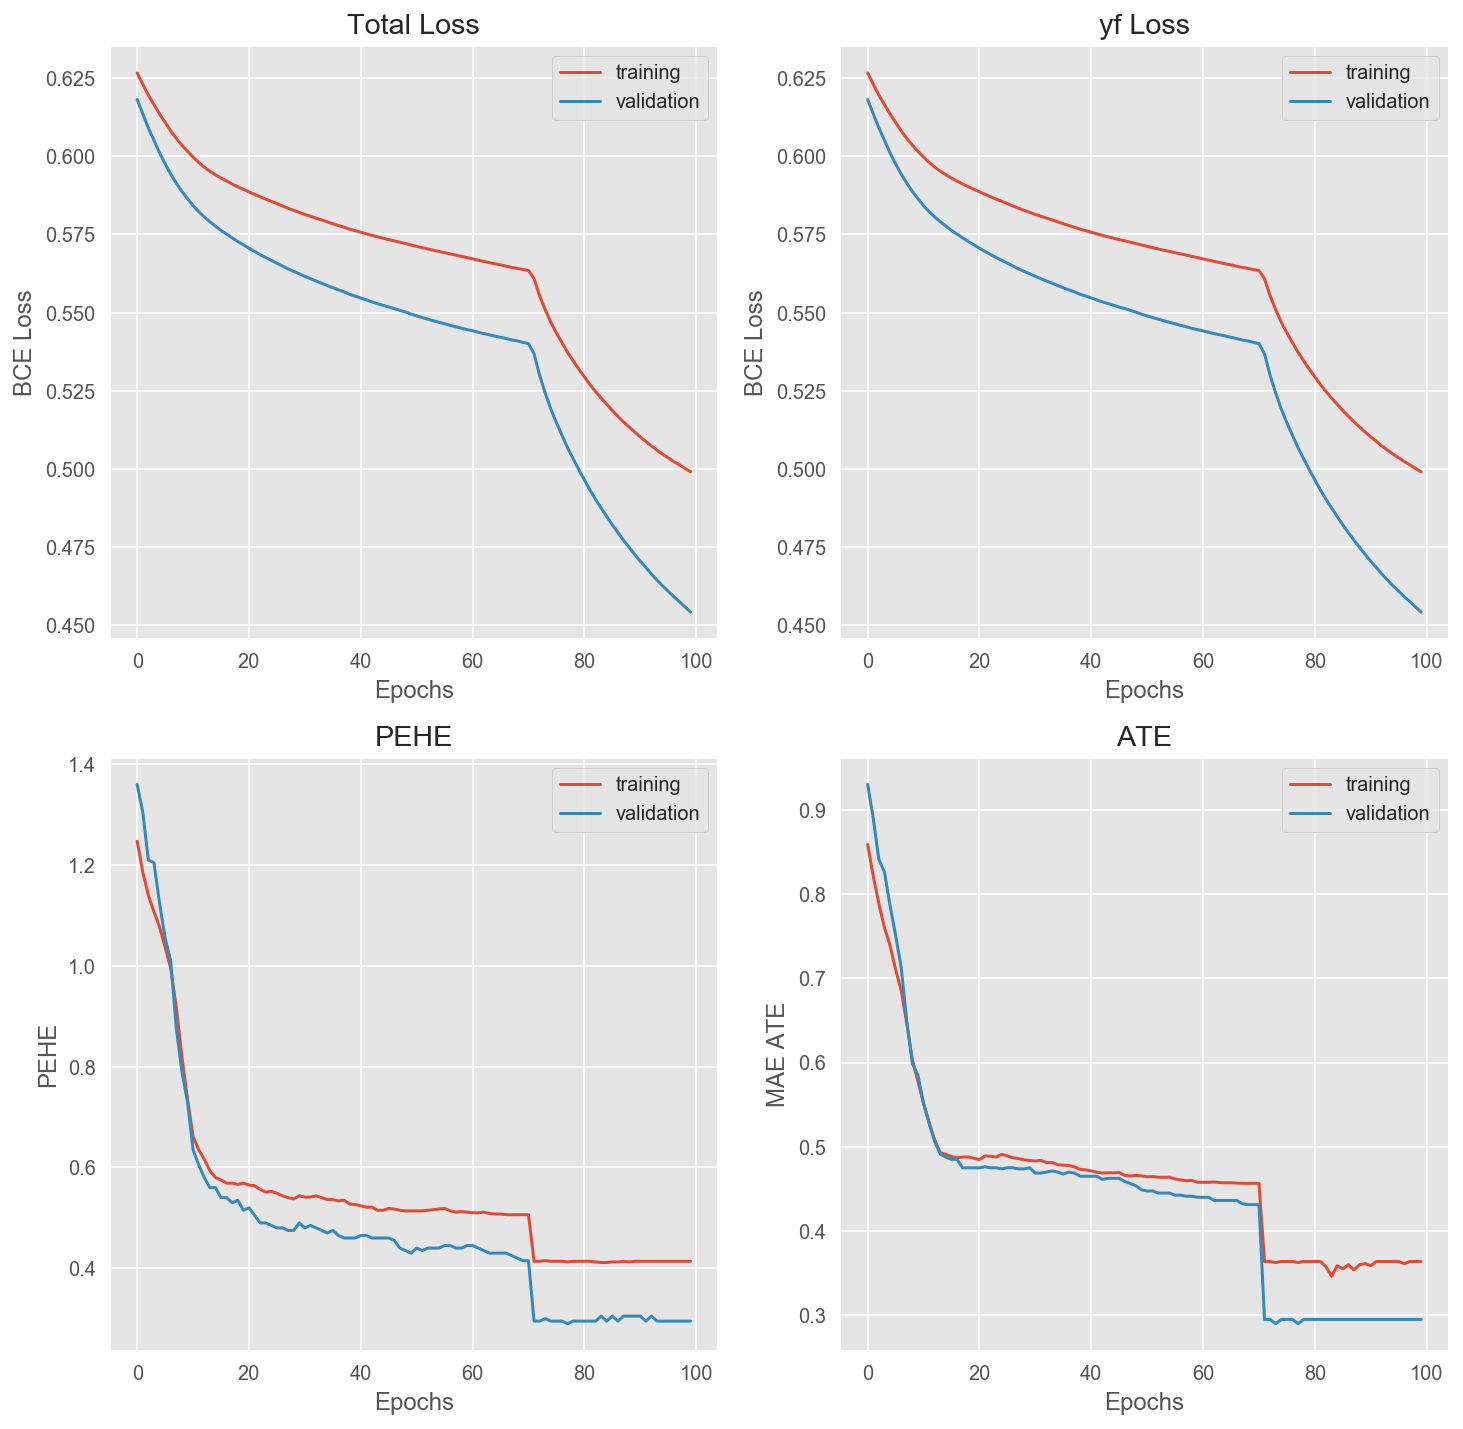

In [25]:
def run_tarnet(num_epochs, lr, train_loader, test_loader):
    model = TARNet(1, activation=nn.ReLU(), device=device)
    optimizer = Adam(model.parameters(), lr=lr)
    yf_loss = nn.BCEWithLogitsLoss(reduction='mean')

    def _prepare_batch(batch):
        x = batch['X'].to(device)
        t = batch['t'].to(device)
        yf = batch['yf'].to(device)
        return x, t, yf

    def process_function(engine, batch):
        optimizer.zero_grad()
        model.train()
        x, t, yf = _prepare_batch(batch)
        y0_pred, y1_pred, phi_x = model(x)
        yf_pred = torch.where(t == 0, y0_pred, y1_pred)
        
        loss_factual = yf_loss(yf_pred, yf)

        tr_loss = loss_factual # + TODO Desc loss
        tr_loss.backward()
        optimizer.step()

        return (
            loss_factual.item(),
            tr_loss.item()
        )

    def evaluate_function(engine, batch):
        model.eval()
        with torch.no_grad():
            x, t, yf = _prepare_batch(batch)
            y0_pred, y1_pred, phi_x = model(x)
            yf_pred = torch.where(t == 0, y0_pred, y1_pred)
            #import pdb; pdb.set_trace()
            return (
                y0_pred, batch['y0'],
                y1_pred, batch['y1'],
                yf_pred, yf
            )

    trainer = Engine(process_function)
    evaluator = Engine(evaluate_function)
    train_evaluator = Engine(evaluate_function)
    pbar = ProgressBar(persist=False)

    ignite_metrics.RunningAverage(output_transform=lambda x: x[0])\
        .attach(trainer, 'tr_factual_loss')
    # pbar.attach(trainer, ['tr_factual_loss'])

    # eval_metrics
    eval_metrics = {
        "factual_loss": ignite_metrics.Loss(
            yf_loss, output_transform=lambda x: [x[4], x[5]]),
        # PEHE is defined as ((y1 - y0)_true - (y1 - y0)_pred)**2 .mean() for each patient
        "pehe": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]) - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])))).pow(2).mean()),
        "mae_ate": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]).mean() - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])).mean())).abs().mean()),
        "ite_true": ignite_metrics.Average(
           output_transform=lambda x: (x[3] - x[1]) * x[3].shape[0]), # we dont want average
        "ite_pred": ignite_metrics.Average(
           output_transform=lambda x:
                x[2].shape[0] * (torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])))),
        "factual_acc": ignite_metrics.Accuracy(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
        "factual_precision": ignite_metrics.Precision(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
        "factual_recall": ignite_metrics.Recall(
            output_transform=lambda x: [torch.round(torch.sigmoid(x[4])), x[5]]),
    }
    # eval_metrics['pehe'] = (eval_metrics['ite_true'] - eval_metrics['ite_pred']).pow(2).mean()
    # eval_metrics['mae_ate'] = (eval_metrics['ite_true'].mean() - eval_metrics['ite_pred'].mean()).abs().mean()
    eval_metrics['total_loss'] = eval_metrics['factual_loss']

    for eval_engine in [evaluator, train_evaluator]:
        for name, metric in eval_metrics.items():
            metric.attach(eval_engine, name)

    tr_metrics_history = {k: [] for k in eval_metrics.keys()}
    val_metrics_history = {k: [] for k in eval_metrics.keys()}

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation(engine):
        if device == "cuda":
            torch.cuda.synchronize()
        train_evaluator.run(train_loader)
        evaluator.run(test_loader)

    def handle_logs(evaluator, trainer, mode, metrics_history):
        metrics = evaluator.state.metrics
        factual_loss = metrics['factual_loss']
        avg_loss = metrics['total_loss']
        # import pdb; pdb.set_trace()
        for key, value in evaluator.state.metrics.items():
            metrics_history[key].append(value)

        print_str = f"{mode} Results - Epoch {trainer.state.epoch} - "+\
                    f"Avg yf loss: {factual_loss:.4f} " +\
                    f"Avg loss: {avg_loss:.4f} " +\
                    f"PEHE: {metrics['pehe']:.4f} " +\
                    f"MAE ATE: {metrics['mae_ate']:.4f} " +\
                    f"acc: {metrics['factual_acc']:.4f} " +\
                    f"true ITE: {metrics['ite_true'].mean():.4f} " +\
                    f"pred ITE: {metrics['ite_pred'].mean():.4f} " +\
                    f"precision: {metrics['factual_precision']:.4f}."
                    # f"recall: {metrics['factual_recall']:.4f} " +\
                    # f"precision: {metrics['factual_precision']:.4f}."

        print(print_str)

    train_evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Training',
        tr_metrics_history
    )
    evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Validate',
        val_metrics_history
    )

    trainer.run(train_loader, max_epochs=num_epochs)

    # Plot training curve
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='validation')
        ax[0, 0].set_xlabel('Epochs')
        ax[0, 0].set_ylabel('BCE Loss')
        ax[0, 0].set_title('Total Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='validation')
        ax[0, 1].set_xlabel('Epochs')
        ax[0, 1].set_ylabel('BCE Loss')
        ax[0, 1].set_title('yf Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['pehe'], ax=ax[1, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['pehe'], ax=ax[1, 0], err_style=None, label='validation')
        ax[1, 0].set_xlabel('Epochs')
        ax[1, 0].set_ylabel('PEHE')
        ax[1, 0].set_title('PEHE')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['mae_ate'], ax=ax[1, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['mae_ate'], ax=ax[1, 1], err_style=None, label='validation')
        ax[1, 1].set_xlabel('Epochs')
        ax[1, 1].set_ylabel('MAE ATE')
        ax[1, 1].set_title('ATE')

run_tarnet(100, 1e-4, train_loader, test_loader)

In [34]:
!pip install tqdm

In [26]:
class FullyConnected(nn.Sequential):
    """
    Fully connected multi-layer network with ELU activations.
    """
    def __init__(self, sizes, final_activation=None):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        if final_activation is not None:
            layers.append(final_activation)
        super().__init__(*layers)

    def append(self, layer):
        assert isinstance(layer, nn.Module)
        self.add_module(str(len(self)), layer)


class DistributionNet(nn.Module):
    """
    Base class for distribution nets.
    """
    @staticmethod
    def get_class(dtype):
        """
        Get a subclass by a prefix of its name, e.g.::

            assert DistributionNet.get_class("bernoulli") is BernoulliNet
        """
        for cls in DistributionNet.__subclasses__():
            if cls.__name__.lower() == dtype + "net":
                return cls
        raise ValueError("dtype not supported: {}".format(dtype))

class DiagNormalNet(nn.Module):
    """
    :class:`FullyConnected` network outputting a constrained ``loc,scale``
    pair.

    This is used to represent a conditional probability distribution of a
    ``sizes[-1]``-sized diagonal Normal random variable conditioned on a
    ``sizes[0]``-size real value, for example::

        net = DiagNormalNet([3, 4, 5])
        z = torch.randn(3)
        loc, scale = net(z)
        x = dist.Normal(loc, scale).sample()

    This is intended for the latent ``z`` distribution and the prewhitened
    ``x`` features, and conservatively clips ``loc`` and ``scale`` values.
    """
    def __init__(self, sizes):
        assert len(sizes) >= 2
        self.dim = sizes[-1]
        super().__init__()
        self.fc = FullyConnected(sizes[:-1] + [self.dim * 2])
        

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., :self.dim].clamp(min=-1e2, max=1e2)
        scale = nn.functional.softplus(
            loc_scale[..., self.dim:]).add(1e-3).clamp(max=1e2)
        return loc, scale

class BernoulliNet(DistributionNet):
    """
    :class:`FullyConnected` network outputting a single ``logits`` value.

    This is used to represent a conditional probability distribution of a
    single Bernoulli random variable conditioned on a ``sizes[0]``-sized real
    value, for example::

        net = BernoulliNet([3, 4])
        z = torch.randn(3)
        logits, = net(z)
        t = net.make_dist(logits).sample()
    """
    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [1])

    def forward(self, x):
        logits = self.fc(x).squeeze(-1).clamp(min=-10, max=10)
        return logits,

    @staticmethod
    def make_dist(logits):
        return dist.Bernoulli(logits=logits)


class Decoder(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim=4, 
        num_hidden=2,
        activation=nn.ELU(), 
        z_dim=2, 
        device='cpu'
    ):
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim

        # p(x|z)
        self.hidden_x_nn = FullyConnected(
            [z_dim] +
            (num_hidden-1) * [hidden_dim] +#Why num_hidden-1?
            [1],
            activation
        )

        # p(t|z)
        self.treatment_logits_nn = BernoulliNet(
            [z_dim]
        )

        # p(y|t,z)
        # TODO doesnt look like this is TARNet
        self.y0_nn = BernoulliNet(
            [z_dim] +
            num_hidden * [hidden_dim],
        )

        self.y1_nn = BernoulliNet(
            [z_dim] +
            num_hidden * [hidden_dim]
        )

    def forward(self, z):
        x = self.hidden_x_nn.forward(z)
        t_logits, = self.treatment_logits_nn(z)
        t = dist.Bernoulli(logits=t_logits).sample()

        params0 = self.y0_nn(z)
        params1 = self.y1_nn(z)
        t = t.bool()

        params = [torch.where(t, p1, p0) for p0, p1 in zip(params0, params1)]
        # y_distribution = self.y0_nn.make_dist(*params)
        # y = y_distribution.sample()

        y_mu_t0 = params0[0]
        y_mu_t1 = params1[0]

        return (
            x, t_logits,
            y_mu_t0, y_mu_t1,
        )


class Encoder(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim=2, 
        num_hidden=2, 
        activation=nn.ELU(), 
        z_dim=2, 
        device='cpu'
    ):
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim

        # q(t|x)
        self.q_treatment_logits_nn = BernoulliNet(
            [input_dim]
        )

        # q(y|x,t)
        # this is for shared head
        self.q_outcome_nn = FullyConnected(
            [1] +
            [hidden_dim] * (num_hidden-1),
            activation
        )
        # these are for different outcomes
        self.q_outcome_t0_nn = BernoulliNet(
            [hidden_dim]
        )
        self.q_outcome_t1_nn = BernoulliNet(
            [hidden_dim]
        )

        # q(z|x,t,y)
        self.q_z_nn = FullyConnected(
            [input_dim + 1] +#Why + 1?
            (num_hidden - 1) * [hidden_dim],#Why num_hidden - 1?
            activation
        )
        self.q_z0_nn = DiagNormalNet(#Two different nets here?
            [hidden_dim, z_dim]
        )
        self.q_z1_nn = DiagNormalNet(
            [hidden_dim, z_dim]
        )

    def forward(self, x):
        # q(t|x)
        t_logits, = self.q_treatment_logits_nn.forward(x)
        t = self.q_treatment_logits_nn.make_dist(t_logits)\#This should only be used for out-of-sample, right?
            .sample()  # shape: bs x 1

        # q(y|x,t)
        hqy = self.q_outcome_nn.forward(x)
        params0 = self.q_outcome_t0_nn.forward(hqy)
        params1 = self.q_outcome_t1_nn.forward(hqy)

        y_logits = [torch.where(t == 1, p1, p0) for p0, p1 in zip(params0, params1)]
        y_distribution = self.q_outcome_t0_nn.make_dist(*y_logits)
        y = y_distribution.sample()#Just one sample?

        # q(z|x,t,y)
        hqz = self.q_z_nn.forward(torch.cat((x, y.view(-1, 1)), 1))
        params0 = self.q_z0_nn(hqz)
        params1 = self.q_z1_nn(hqz)
        t = t.unsqueeze(-1)
        params = [torch.where(t == 1, p1, p0) for p0, p1 in zip(params0, params1)]
        z_mu, z_logvar = params[0], params[1]

        # z_mu_t0, z_logvar_t0 = self.q_z0_nn.forward(hqz)
        # z_mu_t1, z_logvar_t1 = self.q_z0_nn.forward(hqz)
        # z_mu = t * z_mu_t1 + (1. - t) * z_mu_t0
        # z_logvar = t * z_logvar_t1 + (1. - t) * z_logvar_t0

        return z_mu, z_logvar, t, y
        

class CEVAE(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim=2, 
        num_hidden=2, 
        activation=nn.ELU(), 
        z_dim=2, 
        device='cpu'
    ):
        super().__init__()

        self.input_dim = input_dim
        self.z_dim = z_dim

        self.encoder = Encoder(
            input_dim, 
            hidden_dim, 
            num_hidden,
            activation,
            z_dim
        )
        self.decoder = Decoder(
            input_dim, 
            hidden_dim, 
            num_hidden,
            activation,
            z_dim
        )

        self.to(device)
        self.float()

    def reparameterize(self, mean, logvar):
        # samples from unit norm and does reparam trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x):
        x = x.reshape(-1, 1)
        z_mean, z_logvar, t_infer, y_infer = self.encoder.forward(x)

        z = self.reparameterize(z_mean, z_logvar)

        (x_reconc, t_logits,
            y_mu_t0, y_mu_t1) = self.decoder(z)

        # t = torch.sigmoid(t_logits).view(-1)

        # y0_pred = self.decoder.y0_nn.make_dist(y_mu_t0).sample().squeeze(-1)
        # y1_pred = self.decoder.y0_nn.make_dist(y_mu_t1).sample().squeeze(-1)

        return (
            x_reconc.squeeze(-1), t_logits.squeeze(-1), 
            y_mu_t0.squeeze(-1), y_mu_t1.squeeze(-1), 
            z_mean, z_logvar,
            t_infer.squeeze(-1), y_infer.squeeze(-1)
        )

Training Results - Epoch 1 - yf loss: 0.6726 reconc loss: 15.8925 kld loss: 0.4387 avg loss: 18.4738 PEHE: 0.6775 MAE ATE: 0.6100 precision: 0.5702.
Validate Results - Epoch 1 - yf loss: 0.6703 reconc loss: 15.9502 kld loss: 0.4316 avg loss: 18.5039 PEHE: 0.6850 MAE ATE: 0.6650 precision: 0.5714.
Training Results - Epoch 2 - yf loss: 0.7307 reconc loss: 15.3829 kld loss: 0.5111 avg loss: 18.0947 PEHE: 0.6863 MAE ATE: 0.6362 precision: 0.5675.
Validate Results - Epoch 2 - yf loss: 0.7360 reconc loss: 15.6274 kld loss: 0.5284 avg loss: 18.3437 PEHE: 0.7050 MAE ATE: 0.7050 precision: 0.5650.
Training Results - Epoch 3 - yf loss: 0.6595 reconc loss: 13.1671 kld loss: 2.2216 avg loss: 17.5182 PEHE: 0.4963 MAE ATE: 0.1762 precision: 0.7404.
Validate Results - Epoch 3 - yf loss: 0.6481 reconc loss: 13.0380 kld loss: 2.2444 avg loss: 17.3823 PEHE: 0.3950 MAE ATE: 0.1750 precision: 0.7518.
Training Results - Epoch 4 - yf loss: 0.7139 reconc loss: 14.0285 kld loss: 1.2562 avg loss: 17.4686 PEHE:

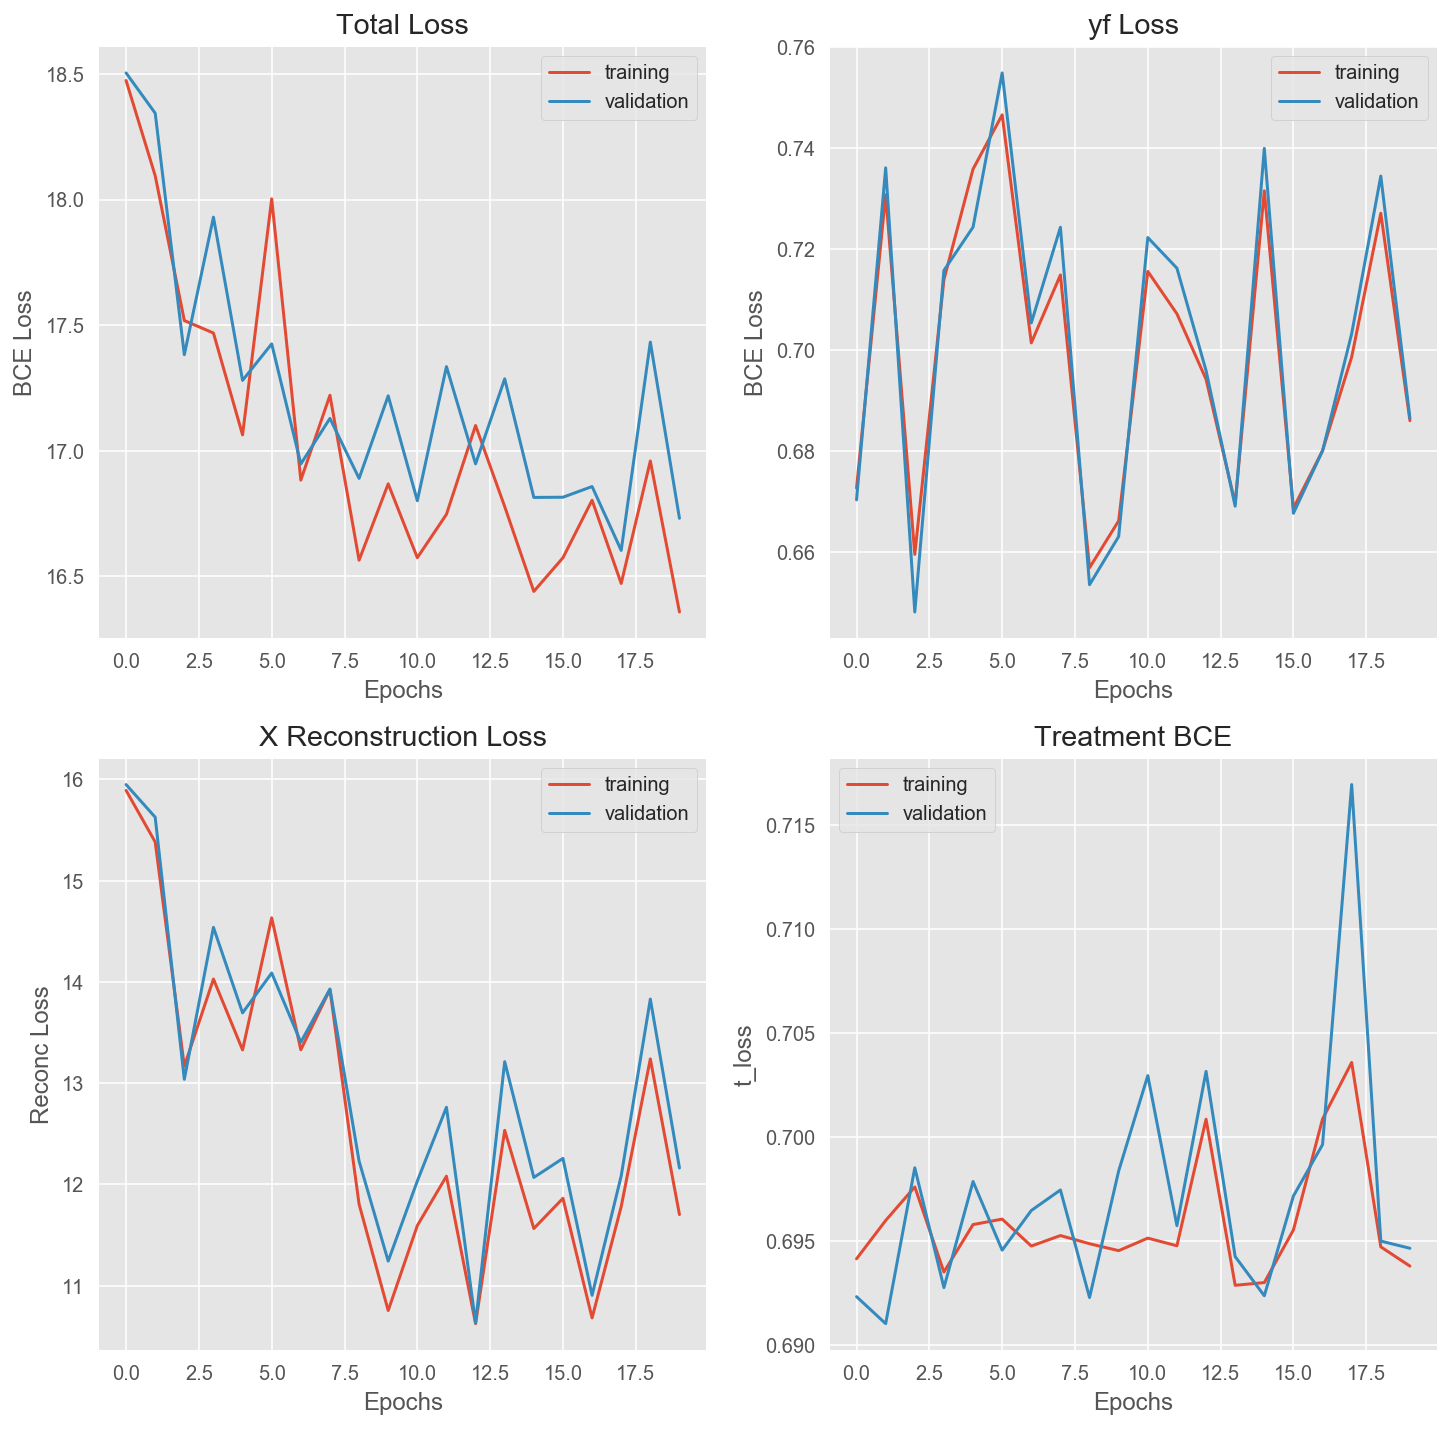

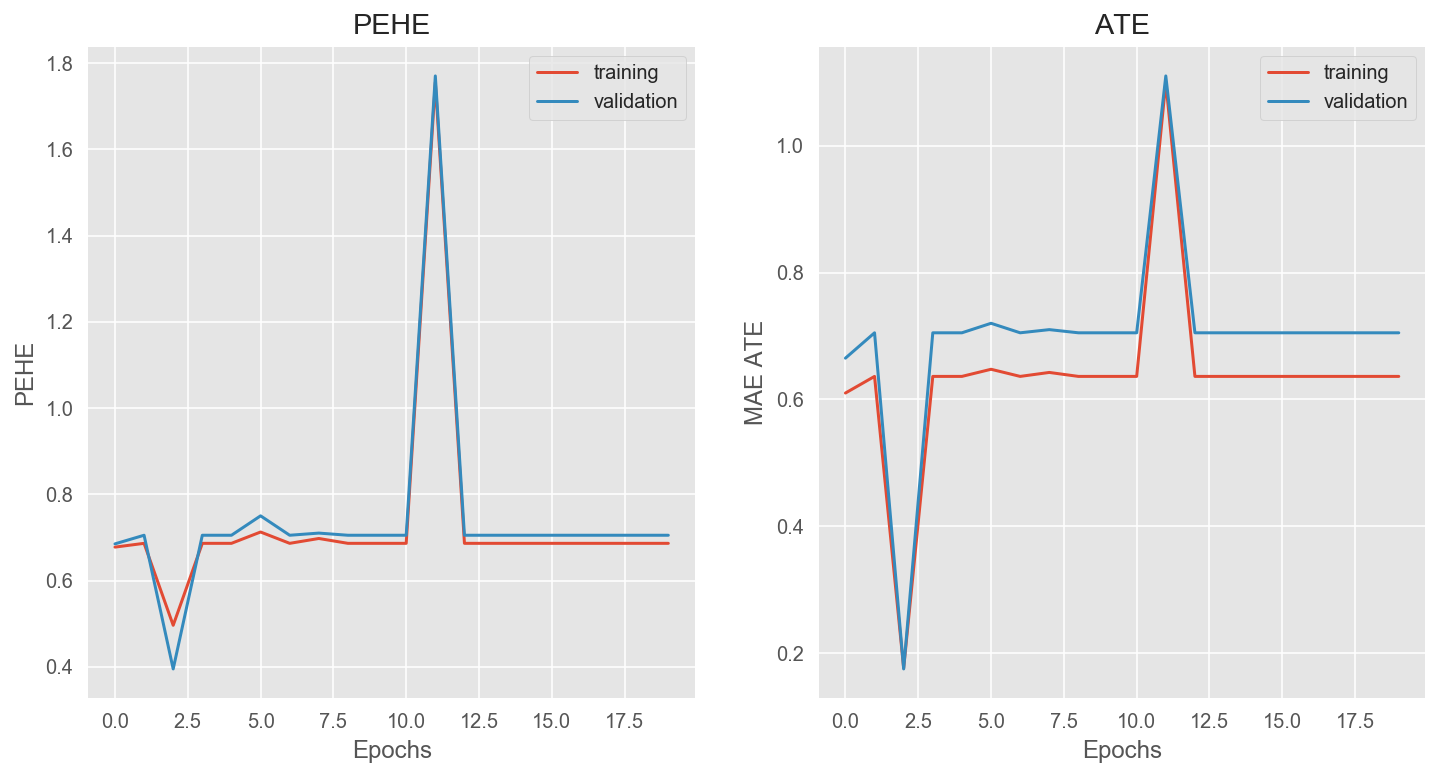

In [27]:
def kld_loss(mu, logvar, kld_coef=1.):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kld_coef * kld

def run_cevae(num_epochs, lr, train_loader, test_loader):
    model = CEVAE(1, activation=nn.ReLU(), device=device)
    optimizer = Adam(model.parameters(), lr=lr)

    yf_loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    t_loss_fn = nn.BCEWithLogitsLoss(reduction='mean')
    reconc_loss_fn = nn.MSELoss(reduction='mean')

    t_aux_loss_fn = nn.BCELoss(reduction='mean')
    y_aux_loss_fn = nn.BCELoss(reduction='mean')

    def _prepare_batch(batch):
        x = batch['X'].to(device)
        t = batch['t'].to(device)
        yf = batch['yf'].to(device)
        return x, t, yf

    def process_function(engine, batch):
        optimizer.zero_grad()
        model.train()
        x, t, yf = _prepare_batch(batch)
        (x_reconc, t_pred, y0_pred, 
            y1_pred, z_mean, z_logvar, t_infer, y_infer) = model(x)
        
        yf_pred = torch.where(rounded_sigmoid(t_pred) == 0, y0_pred, y1_pred)
        
        mse_loss = reconc_loss_fn(x_reconc, x) 
        t_loss = t_loss_fn(t_pred, t)
        yf_loss = yf_loss_fn(yf_pred, yf)
        kld = kld_loss(z_mean, z_logvar)

        # aux losses
        t_aux_loss = t_aux_loss_fn(t_infer, t)
        y_aux_loss = y_aux_loss_fn(y_infer, yf)

        tr_loss = yf_loss + t_loss + mse_loss + kld + t_aux_loss + y_aux_loss
        tr_loss.backward()
        optimizer.step()

        return (
            yf_loss.item(),
            kld.item(),
            tr_loss.item(),
            t_loss.item(),
            t_aux_loss.item(),
            y_aux_loss.item()
        )

    def evaluate_function(engine, batch):
        model.eval()
        with torch.no_grad():
            x, t, yf = _prepare_batch(batch)
            (x_reconc, t_pred, y0_pred, 
                y1_pred, z_mean, z_logvar, t_infer, y_infer) = model(x)
            yf_pred = torch.where(t == 0, y0_pred, y1_pred)
            return (
                y0_pred, batch['y0'],
                y1_pred, batch['y1'],
                yf_pred, yf,
                x_reconc, x,
                z_mean, z_logvar,
                t_pred, t,
                t_infer, y_infer
            )

    trainer = Engine(process_function)
    evaluator = Engine(evaluate_function)
    train_evaluator = Engine(evaluate_function)
    pbar = ProgressBar(persist=False)

    ignite_metrics.RunningAverage(output_transform=lambda x: x[0])\
        .attach(trainer, 'tr_factual_loss')
    # pbar.attach(trainer, ['tr_factual_loss'])


    # eval_metrics
    eval_metrics = {
        "factual_loss": ignite_metrics.Loss(
            yf_loss_fn, output_transform=lambda x: [x[4], x[5]]),
        "reconc_loss": ignite_metrics.Loss(
            reconc_loss_fn, output_transform=lambda x: [x[6], x[7]]),
        "kld_loss": ignite_metrics.Loss(
            kld_loss, output_transform=lambda x: [x[8], x[9]]),
        "t_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x[10], x[11]]),
        "taux_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x[12], x[11]]),
        "yaux_loss": ignite_metrics.Loss(
            t_loss_fn, output_transform=lambda x: [x[13], x[5]]),
        # PEHE is defined as ((y1 - y0)_true - (y1 - y0)_pred)**2 .mean() for each patient
        "pehe": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]) - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])))).pow(2).mean()),
        "mae_ate": ignite_metrics.Average(
           output_transform=lambda x: ((x[3] - x[1]).mean() - (
               torch.round(torch.sigmoid(x[2])) - torch.round(torch.sigmoid(x[0])).mean())).abs().mean()),            
        # "ite_true": ignite_metrics.Average(
        #    output_transform=lambda x: x[3] - x[1]),
        # "ite_pred": ignite_metrics.Average(
        #    output_transform=lambda x: rounded_sigmoid(x[2]) - rounded_sigmoid(x[0])),
        "factual_acc": ignite_metrics.Accuracy(
            output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
        "factual_precision": ignite_metrics.Precision(
            output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
        "factual_recall": ignite_metrics.Recall(
            output_transform=lambda x: [rounded_sigmoid(x[4]), rounded_sigmoid(x[5])]),
    }
    # eval_metrics['pehe'] = (eval_metrics['ite_true'] - eval_metrics['ite_pred']).pow(2).mean()
    # eval_metrics['mae_ate'] = (eval_metrics['ite_true'].mean() - eval_metrics['ite_pred'].mean()).abs().mean()
    eval_metrics['total_loss'] = (eval_metrics['factual_loss'] + 
                                  eval_metrics['reconc_loss'] + 
                                  eval_metrics['kld_loss'] + 
                                  eval_metrics['taux_loss'] + 
                                  eval_metrics['yaux_loss'])

    for eval_engine in [evaluator, train_evaluator]:
        for name, metric in eval_metrics.items():
            metric.attach(eval_engine, name)

    tr_metrics_history = {k: [] for k in eval_metrics.keys()}
    val_metrics_history = {k: [] for k in eval_metrics.keys()}

    @trainer.on(Events.EPOCH_COMPLETED)
    def run_validation(engine):
        if device == "cuda":
            torch.cuda.synchronize()
        train_evaluator.run(train_loader)
        evaluator.run(test_loader)

    def handle_logs(evaluator, trainer, mode, metrics_history):
        metrics = evaluator.state.metrics
        factual_loss = metrics['factual_loss']
        avg_loss = metrics['total_loss']
        # import pdb; pdb.set_trace()
        for key, value in evaluator.state.metrics.items():
            metrics_history[key].append(value)

        print_str = f"{mode} Results - Epoch {trainer.state.epoch} - "+\
                    f"yf loss: {factual_loss:.4f} " +\
                    f"reconc loss: {metrics['reconc_loss']:.4f} " +\
                    f"kld loss: {metrics['kld_loss']:.4f} " +\
                    f"avg loss: {avg_loss:.4f} " +\
                    f"PEHE: {metrics['pehe']:.4f} " +\
                    f"MAE ATE: {metrics['mae_ate']:.4f} " +\
                    f"precision: {metrics['factual_precision']:.4f}."
                    # f"true ITE: {metrics['ite_true'].sum():.4f} " +\
                    # f"pred ITE: {metrics['ite_pred'].sum():.4f} " +\
                    # f"acc: {metrics['factual_acc']:.4f} "
                    # f"recall: {metrics['factual_recall']:.4f} " +\
                    # f"precision: {metrics['factual_precision']:.4f}."

        print(print_str)

    train_evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Training',
        tr_metrics_history
    )
    evaluator.add_event_handler(
        Events.COMPLETED,
        handle_logs,
        trainer,
        'Validate',
        val_metrics_history
    )

    trainer.run(train_loader, max_epochs=num_epochs)

    # Plot training curve
    with plt.style.context(PLOT_STYLE):
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['total_loss'], ax=ax[0, 0], err_style=None, label='validation')
        ax[0, 0].set_xlabel('Epochs')
        ax[0, 0].set_ylabel('BCE Loss')
        ax[0, 0].set_title('Total Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['factual_loss'], ax=ax[0, 1], err_style=None, label='validation')
        ax[0, 1].set_xlabel('Epochs')
        ax[0, 1].set_ylabel('BCE Loss')
        ax[0, 1].set_title('yf Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['reconc_loss'], ax=ax[1, 0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['reconc_loss'], ax=ax[1, 0], err_style=None, label='validation')
        ax[1, 0].set_xlabel('Epochs')
        ax[1, 0].set_ylabel('Reconc Loss')
        ax[1, 0].set_title('X Reconstruction Loss')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['t_loss'], ax=ax[1, 1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['t_loss'], ax=ax[1, 1], err_style=None, label='validation')
        ax[1, 1].set_xlabel('Epochs')
        ax[1, 1].set_ylabel('t_loss')
        ax[1, 1].set_title('Treatment BCE')

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['pehe'], ax=ax[0], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['pehe'], ax=ax[0], err_style=None, label='validation')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('PEHE')
        ax[0].set_title('PEHE')

        sns.lineplot(x=range(num_epochs), y=tr_metrics_history['mae_ate'], ax=ax[1], err_style=None, label='training')
        sns.lineplot(x=range(num_epochs), y=val_metrics_history['mae_ate'], ax=ax[1], err_style=None, label='validation')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('MAE ATE')
        ax[1].set_title('ATE')

run_cevae(20, 3e-2, train_loader, test_loader)